In [7]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "4"


fpkm shape: (887, 60660)
deconvo shape: (835, 9853)
tpm shape: (887, 60660)
event.PAM50
LumA     464
LumB     193
Basal    146
Her2      74
Name: count, dtype: int64


Fitting size factors...
... done in 5.24 seconds.

Fitting dispersions...
... done in 34.10 seconds.

Fitting dispersion trend curve...
... done in 38.30 seconds.

Fitting MAP dispersions...
... done in 48.96 seconds.

Fitting LFCs...
... done in 123.91 seconds.

Refitting 31235 outliers.

Fitting dispersions...
... done in 1.48 seconds.

Fitting MAP dispersions...
... done in 1.92 seconds.

Fitting LFCs...
... done in 5.51 seconds.

Running Wald tests...
... done in 97.50 seconds.



Log2 fold change & Wald test p-value: HRD-status-base HRD vs HR


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
5S_0,0.000000,NaN,NaN,NaN,NaN,NaN
5S_1,0.333534,-0.184648,0.260358,-0.709207,0.478196,0.778367
5S_2,0.000000,NaN,NaN,NaN,NaN,NaN
5S_3,0.022364,0.193869,2.149904,0.090176,0.928148,NaN
5S_4,0.063604,-0.168719,0.848173,-0.198921,0.842325,NaN
...,...,...,...,...,...,...
ZZEF1_665835,13.423302,-0.193599,0.046159,-4.194207,0.000027,0.000218
ZZZ3_665836,21.292276,0.077048,0.046185,1.668222,0.095272,0.247042
hsa-mir-1253_665837,0.001042,0.029647,3.438974,0.008621,0.993122,NaN
hsa-mir-423_665838,0.000000,NaN,NaN,NaN,NaN,NaN


Mean Squared Error: 0.035
R^2 Score: 0.615


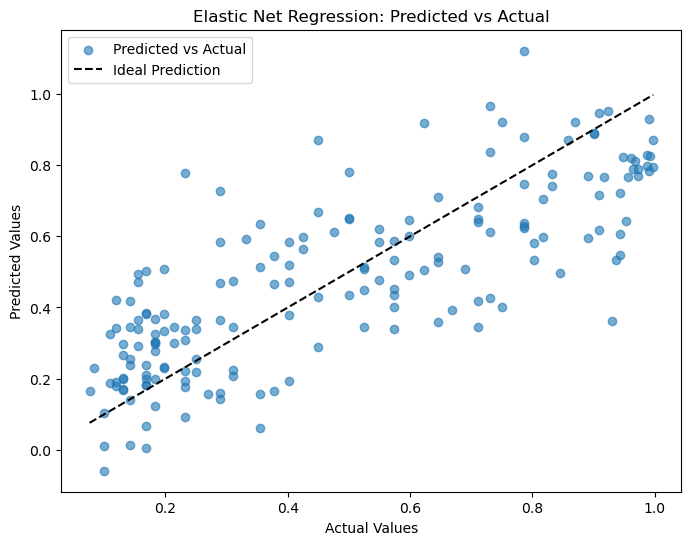

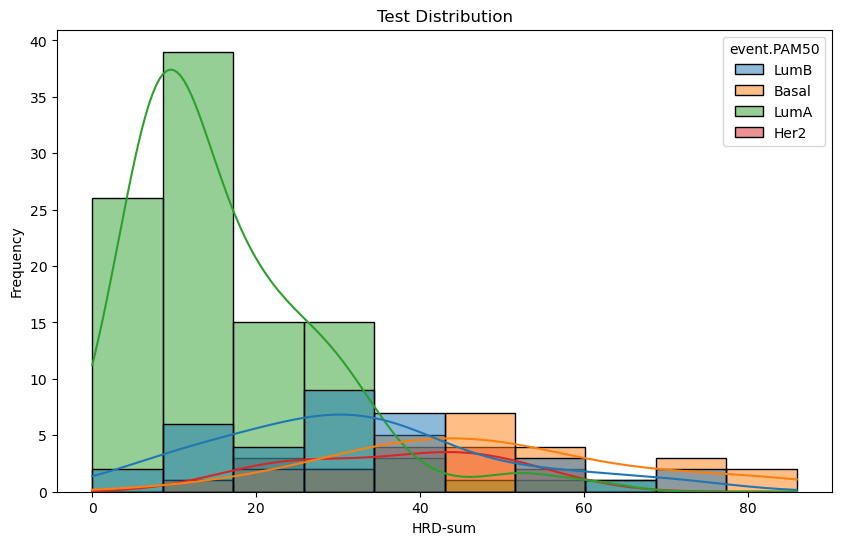

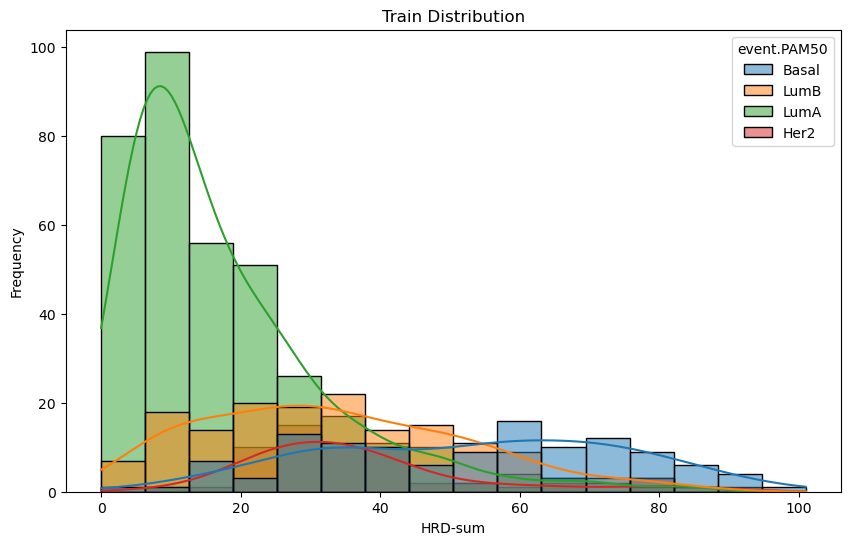

In [8]:
import pandas as pd
from joblib import Parallel, delayed
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

# -------------------- Data Loading and Preprocessing --------------------

# Load metadata and HRD scores
ann_tcga = pd.read_csv('../data/toga.breast.brca.status.txt', sep='\t', index_col=0)
hrd_scores = pd.read_excel('../data/tcga.hrdscore.xlsx', index_col=0)

# Load RNAseq data
fpkm = pd.read_csv('../data/tcga.brca.rnaseq.unstranded.fpkm.counts.matrix.txt', sep='\t', index_col=0)
deconvo = pd.read_csv('../data/Deconvo2.csv',  index_col=0)
tpm = pd.read_csv('../data/tpm.csv', index_col=0, low_memory=False)

# Filter metadata
metadata = ann_tcga[~ann_tcga['event.RAD51C'].ne('0')]
metadata = metadata[~metadata['event.PALB2'].ne('0')]
metadata = metadata[metadata['event.BRCA1'] != '1']
metadata.index = metadata.index.str.replace('.', '-', regex=False)
hrd_scores.index = hrd_scores.index.map(lambda x: x[:12])
metadata = metadata.merge(hrd_scores[['HRD-sum']], left_index=True, right_index=True, how='inner')

# Process fpkm data
fpkm = fpkm.set_index('Case ID')
fpkm = fpkm[fpkm['Sample Type'] == 'Primary Tumor']
fpkm = fpkm.drop(columns=["Sample ID","Sample Type"])

# Rename columns using a dictionary constructed from fpkm columns
dick = {}
for i, v in enumerate(fpkm.columns):
    parts = v.split('|')
    if len(parts) > 1:
        dick[parts[0]] = parts[1]
tpm = tpm.rename(columns=dick)
tpm = tpm[~tpm.index.duplicated(keep='first')]

# Keep only Primary Tumor samples in tpm
tpm = tpm.loc[tpm.index.str[13:15] == "01"]

# Further processing for fpkm
fpkm.columns = [col.split('|')[1] if '|' in col else col for col in fpkm.columns]
fpkm.index = fpkm.index.map(lambda x: x[:12])
fpkm = fpkm.loc[fpkm.index.intersection(metadata.index)]
fpkm.sort_index(inplace=True)
fpkm = fpkm.rename_axis("fpkm", axis="index")
fpkm = fpkm.apply(pd.to_numeric, errors='coerce')
fpkm.fillna(0, inplace=True)

# Process deconvo
deconvo.index = deconvo.index.map(lambda x: x[:12])
deconvo = deconvo.loc[deconvo.index.intersection(metadata.index)]
deconvo.sort_index(inplace=True)
deconvo = deconvo.rename_axis("deconvo", axis="index")
deconvo.fillna(0, inplace=True)

# Process tpm
tpm.index = tpm.index.map(lambda x: x[:12])
tpm = tpm.loc[tpm.index.intersection(metadata.index)]
tpm.sort_index(inplace=True)
tpm = tpm.rename_axis("tpm", axis="index")
tpm = tpm.apply(pd.to_numeric, errors='coerce')
tpm.fillna(0, inplace=True)

print(f"fpkm shape: {fpkm.shape}")
print(f"deconvo shape: {deconvo.shape}")
print(f"tpm shape: {tpm.shape}")

# Display counts for PAM50 subtypes
pam50_counts = metadata['event.PAM50'].value_counts()
print(pam50_counts)

# -------------------- Helper Functions --------------------

def downsampling_lumA(metadata, lumA_cutoff):
    """Downsamples LumA samples to match HRD count."""
    lumA_HRD = metadata[(metadata['event.PAM50'] == 'LumA') & (metadata['HRD-sum'] >= lumA_cutoff)]
    lumA_HRP = metadata[(metadata['event.PAM50'] == 'LumA') & (metadata['HRD-sum'] < lumA_cutoff)]
    if lumA_HRP.shape[0] < lumA_HRD.shape[0]:
        return metadata, pd.DataFrame()
    lumA_HRP_downsampled = lumA_HRP.sample(n=lumA_HRD.shape[0], random_state=42)
    df_downsampled = pd.concat([lumA_HRD, lumA_HRP_downsampled])
    df_downsampled = pd.concat([df_downsampled, metadata[metadata['event.PAM50'] != 'LumA']])
    unused_majority = lumA_HRP.loc[~lumA_HRP.index.isin(lumA_HRP_downsampled.index)]
    return df_downsampled, unused_majority

def add_back_test(rna_df, removed_samples, X_test, y_test):
    """Adds back removed samples to the test set if required."""
    add_back_features = rna_df.loc[rna_df.index.intersection(removed_samples.index)]
    add_back_features = add_back_features.sort_index()
    add_back_y = removed_samples.loc[removed_samples.index.intersection(rna_df.index)]
    add_back_y = add_back_y.sort_index()
    X_test = pd.concat([X_test, add_back_features])
    y_test = pd.concat([y_test, add_back_y['HRD-sum'].squeeze()])
    return X_test, y_test

def sigmoid_transform(values, shift=0, scale=1):
    """Apply sigmoid transformation to a series of values."""
    return 1 / (1 + np.exp(-scale * (values - shift)))

def binary_hrd(values, threshold):
    """Convert continuous HRD values into binary classes based on a threshold."""
    return (values >= threshold).astype(int)

def plot_test_train_pam50_dist(metadata, X_train, X_test):
    """Plot HRD-sum distributions for training and test samples, colored by PAM50 subtype."""
    plt.figure(figsize=(10, 6))
    sns.histplot(data=metadata.loc[metadata.index.intersection(X_test.index)],
                 x='HRD-sum', hue='event.PAM50', multiple='layer', kde=True)
    plt.title('Test Distribution')
    plt.xlabel('HRD-sum')
    plt.ylabel('Frequency')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.histplot(data=metadata.loc[metadata.index.intersection(X_train.index)],
                 x='HRD-sum', hue='event.PAM50', multiple='layer', kde=True)
    plt.title('Train Distribution')
    plt.xlabel('HRD-sum')
    plt.ylabel('Frequency')
    plt.show()

def runDESeq2(counts, metadata, design_factors):
    """Run differential expression analysis using DESeq2 (via pydeseq2)."""
    counts = counts.copy()
    # Make gene names unique
    counts.columns = pd.Index(counts.columns).str.split('_').str[0] + '_' + pd.Series(range(len(counts.columns))).astype(str)
    dds = DeseqDataSet(
        counts=counts,
        metadata=metadata,
        design_factors=design_factors,
        # n_jobs=-1
    )
    dds.deseq2()
    stats = DeseqStats(dds)
    stats.summary()
    results = stats.results_df
    return results

def check_deseq2_data(counts_df, metadata_df, design_factor):
    common_indices = counts_df.index.intersection(metadata_df.index)    
    return common_indices

def prepare_deseq2_data(counts_df, metadata_df, common_indices):
    counts_aligned = counts_df.loc[common_indices]
    metadata_aligned = metadata_df.loc[common_indices]
    assert counts_aligned.index.equals(metadata_aligned.index), "Indices not aligned"
    assert counts_aligned.index.is_unique, "Duplicate indices present"
    return counts_aligned, metadata_aligned

# -------------------- Prepare Data for DESeq2 --------------------

# Use tpm as your gene expression data
features_df = tpm
metadata_truncated = metadata.loc[metadata.index.intersection(features_df.index)]
# Add a base HRD status (not used in the final regression but for DESeq2 design)
metadata_truncated['HRD_status_base'] = metadata_truncated['HRD-sum'].apply(lambda x: 'HRD' if x >= 42 else 'HR')
softLabel_metadata = metadata_truncated.sort_index()

features_df = features_df.fillna(0).astype(int)
features_df = features_df[sorted(features_df.columns)]
gene_expression_int = features_df.sort_index()
common_idx = check_deseq2_data(gene_expression_int, softLabel_metadata, 'HRD_status_base')
gene_expression_aligned, softLabel_metadata_aligned = prepare_deseq2_data(
    gene_expression_int, 
    softLabel_metadata,
    common_idx
)
basic = runDESeq2(gene_expression_aligned, softLabel_metadata_aligned, 'HRD_status_base')

# -------------------- Model Training Function --------------------

def train_model(params, metadata):
    # Filter differential expression results based on the provided p-value and fold-change thresholds
    basic_filt = basic[(basic["padj"] <= params['pvals']) &
                       ((basic["log2FoldChange"] >= 2) | (basic["log2FoldChange"] <= -2))]
    # Extract gene names (removing the added unique suffix)
    de_genes = [gene.split('_')[0] for gene in basic_filt.index]

    # Subset the expression data to only include DE genes
    features_df = gene_expression_int.loc[:, gene_expression_int.columns.isin(de_genes)]
    labels_df = metadata_truncated['HRD-sum'].sort_index()
    features_df = features_df.sort_index()
    
    # Normalize features if requested
    if params['normalization'] == 'StandardScaler':
        scaler = StandardScaler()
        features_df = pd.DataFrame(scaler.fit_transform(features_df), index=features_df.index, columns=features_df.columns)
    elif params['normalization'] == 'log2':
        features_df = np.log2(features_df + 1)
    
    # Apply soft labeling
    if params['softlabels'] == "Sigmoid":
        labels_df = sigmoid_transform(labels_df, params['softlabel_thresholds'], params['softlabel_gradients'])
    elif params['softlabels'] == "Binary":
        labels_df = binary_hrd(labels_df, params['softlabel_thresholds'])
    
    # Optionally downsample LumA samples (here, we are not downsampling because fixed params indicate False)
    removed_samples = None
    if params['downsample'][0]:
        df_downsampled, removed_samples = downsampling_lumA(metadata_truncated, params['downsample_thresholds'])
        features_df = features_df.loc[features_df.index.intersection(df_downsampled.index)]
        labels_df = df_downsampled.loc[df_downsampled.index.intersection(features_df.index), 'HRD-sum']
    
    labels = labels_df.squeeze()
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features_df, labels, test_size=0.2, random_state=42)
    
    # Optionally add back removed samples to test set if required
    if params['downsample'][1] and removed_samples is not None:
        X_test, y_test = add_back_test(features_df, removed_samples, X_test, y_test)
    
    # Train the ElasticNet model
    warnings.filterwarnings("ignore")
    model = ElasticNet(alpha=params['alpha'], l1_ratio=params['l1_ratio'], max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    
    # Predict and evaluate on the test set
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return mse, r2, model, X_train, X_test, y_test, y_pred

# -------------------- Run with Fixed Parameters --------------------

# Use the fixed parameters as specified
fixed_params = {
    'softlabels': 'Sigmoid', 
    'softlabel_thresholds': 25, 
    'softlabel_gradients': 0.1, 
    'pvals': 0.01, 
    'normalization': 'log2', 
    'l1_ratio': 0.9, 
    'downsample_thresholds': 35, 
    'downsample': (False, False), 
    'alpha': 0.01
}

# Train the model with the fixed parameters
mse, r2, model, X_train, X_test, y_test, y_pred = train_model(fixed_params, metadata)

print(f"Mean Squared Error: {mse:.3f}")
print(f"R^2 Score: {r2:.3f}")

# Save the trained model if desired
joblib.dump(model, 'best_model.joblib')

# -------------------- Plotting --------------------

# Plot Predicted vs. Actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', label='Ideal Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Elastic Net Regression: Predicted vs Actual')
plt.legend(loc="upper left")
plt.show()

# Optionally, plot the training and test distribution of HRD-sum (colored by PAM50 subtype)
plot_test_train_pam50_dist(metadata_truncated, X_train, X_test)


In [1]:
import tracemalloc

# Start tracing memory allocations
tracemalloc.start()

# Run your heavy code section
# e.g. running DESeq2 or data loading

# Show top memory-consuming variables
snapshot = tracemalloc.take_snapshot()
top_stats = snapshot.statistics("lineno")

print("\n[Top 10 memory-consuming lines]\n")
for stat in top_stats[:10]:  # Show top 10 memory consumers
    print(stat)



[Top 10 memory-consuming lines]

/opt/homebrew/Caskroom/miniconda/base/envs/hrd/lib/python3.11/codeop.py:125: size=357 B, count=3, average=119 B
/opt/homebrew/Caskroom/miniconda/base/envs/hrd/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3517: size=304 B, count=1, average=304 B
/opt/homebrew/Caskroom/miniconda/base/envs/hrd/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3577: size=152 B, count=1, average=152 B
/opt/homebrew/Caskroom/miniconda/base/envs/hrd/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3566: size=64 B, count=1, average=64 B
/opt/homebrew/Caskroom/miniconda/base/envs/hrd/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3507: size=56 B, count=2, average=28 B
/opt/homebrew/Caskroom/miniconda/base/envs/hrd/lib/python3.11/site-packages/IPython/core/compilerop.py:192: size=32 B, count=1, average=32 B


In [ ]:
# Extract the list of DE genes used for training
top_genes_de = list(features_df.columns)


import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_ind, mannwhitneyu, pearsonr
import joblib

# =============================================================================
# 1. Load the Validation Gene Expression Dataset
# =============================================================================
# This dataset contains gene-level expression values (rows: genes, columns: samples)
ispy2_expr = pd.read_csv('../data/validation/GSE173839_ISPY2_AgilentGeneExp_durvaPlusCtr_FFPE_meanCol_geneLevel_n105.txt', sep='\t', on_bad_lines='skip')
ispy2_response = pd.read_csv('../data/validation/GSE173839_ISPY2_DurvalumabOlaparibArm_biomarkers.csv')
ispy2_expr.set_index('GeneName', inplace=True)

# Transpose so that rows are samples and columns are genes.
ispy2_expr_transposed = ispy2_expr.T
ispy2_expr_transposed.sort_index(inplace=True)
ispy2_expr_transposed.dropna(inplace=True)

# =============================================================================
# 2. Load the Trained Model and Feature List from Training
# =============================================================================
# The training code (see your previous cell) saved the best ElasticNet model as 'best_model.joblib'.
# It also defined the list of features used in training. (For example, after DE analysis you might have done:)
#
#     de_genes = [gene.split('_')[0] for gene in basic_filt.index]
#
# and then used these to subset your training data.
#
# For validation we assume these variables are available:
#   - top_genes_de: a list of gene names used for training (order matters)
#
# (If you saved this list, load it now. For demonstration, uncomment and adjust the following lines:)
# import pickle
# with open('top_genes_de.pkl', 'rb') as f:
#     top_genes_de = pickle.load(f)
#
# For this example, we assume that 'top_genes_de' is already defined.
# If you also saved a “template” DataFrame (e.g., with the training column order), you could load that too.
#
# Now load the trained model:
best_model = joblib.load('best_model.joblib')

# =============================================================================
# 3. Align Validation Data to Training Features
# =============================================================================
# (a) Identify the common features between the training set and the validation set.
print('1')
common_features = list(set(top_genes_de) & set(ispy2_expr_transposed.columns))

# (b) Subset the validation data to those features.
validation_subset = ispy2_expr_transposed.loc[:, common_features]

# (c) In case some training features are missing in the validation data,
#     add them as columns filled with a default value (here, 0).
# missing_features = [feature for feature in top_genes_de if feature not in common_features]
# for feature in missing_features:
#     validation_subset[feature] = 0  # alternatively, you might use the training mean/median for that feature
validation_subset = validation_subset.loc[:, ~validation_subset.columns.duplicated()]

# Identify missing features
missing_features = list(set(top_genes_de) - set(common_features))

# Add missing columns efficiently using reindex
validation_subset = validation_subset.reindex(columns=top_genes_de, fill_value=0)


# (d) Reorder the columns to match the training order.
print(1.1)
validation_subset = validation_subset[top_genes_de]

# (e) Optionally, you may wish to restrict to only those samples that have response data.
# =============================================================================
# 4. Load and Prepare the Response/Clinical Data
# =============================================================================
# Replace -1 with 0 (e.g. for pCR.status if –1 indicates control)
ispy2_response.loc[ispy2_response["pCR.status"] == -1, "pCR.status"] = 0
ispy2_response.sort_values(by='ResearchID', inplace=True)
ispy2_response["ResearchID"] = ispy2_response["ResearchID"].astype(str).str.strip()
ispy2_response.set_index('ResearchID', inplace=True)

# Ensure that the sample indices in the expression data match those in the response data.
# (Here we assume that the index of ispy2_expr_transposed consists of the sample IDs.)
common_indices = validation_subset.index.intersection(ispy2_response.index)
validation_subset = validation_subset.loc[common_indices]

# =============================================================================
# 5. Scale the Data and Predict Using the Trained Model
# =============================================================================
# (Here we use StandardScaler. In practice, you would ideally use the same scaler (or its parameters) from training.)
scaler = StandardScaler()
print(1.2)
scaled_data = scaler.fit_transform(validation_subset)

# Make predictions (regression scores) with the trained ElasticNet model.
predictions = best_model.predict(scaled_data)
print("Predictions:\n", predictions)

# =============================================================================
# 6. Merge Predictions with the Response Data & Plot/Statistical Tests
# =============================================================================
filtered_ispy_response = ispy2_response.loc[common_indices].copy()
filtered_ispy_response['predictions'] = predictions
print(2)
# --- Plot 1: Box Plot by pCR Status ---
fig_box = px.box(filtered_ispy_response,
                 x='pCR.status',
                 y='predictions',
                 points="all",
                 title="Distribution of Regression Scores by pCR Status")
fig_box.show()

# --- Statistical Tests: Welch's t-test and Mann-Whitney U Test ---
group_0 = filtered_ispy_response.loc[filtered_ispy_response['pCR.status'] == 0, 'predictions']
group_1 = filtered_ispy_response.loc[filtered_ispy_response['pCR.status'] == 1, 'predictions']

t_stat, p_value_t = ttest_ind(group_0, group_1, equal_var=False)
print(f"Welch's t-test: t = {t_stat:.4f}, p = {p_value_t:.4f}")

u_stat, p_value_u = mannwhitneyu(group_0, group_1, alternative='two-sided')
print(f"Mann-Whitney U test: U = {u_stat:.4f}, p = {p_value_u:.4f}")

# --- Plot 2: Scatter Plot of PARPi7 Signal vs. Predictions ---
# (Make sure the clinical data contains a column named 'PARPi7_sig.')
if 'PARPi7_sig.' in filtered_ispy_response.columns:
    x = filtered_ispy_response['PARPi7_sig.']
    y = filtered_ispy_response['predictions']
    r_value, p_value_corr = pearsonr(x, y)
    
    fig_scatter = px.scatter(filtered_ispy_response,
                             x='PARPi7_sig.',
                             y='predictions',
                             title="Regression Scores vs PARPi7 Signal",
                             labels={'PARPi7_sig.': 'PARPi7 Signal', 'predictions': 'Predictions'},
                             color='pCR.status',
                             trendline="ols",
                             color_continuous_scale='magenta')
    # Add an annotation with the Pearson correlation coefficient and p-value.
    fig_scatter.add_annotation(
        x=np.mean(x),
        y=np.max(y),
        text=f"Pearson R: {r_value:.2f}<br>p-value: {p_value_corr:.2e}",
        showarrow=False,
        font=dict(size=14, color="black"),
        align="center",
        bordercolor="black",
        borderwidth=1,
        borderpad=4,
        bgcolor="white",
        opacity=1.0
    )
    fig_scatter.show()
else:
    print("Column 'PARPi7_sig.' not found in the response data.")


1
1.1
